<a href="https://colab.research.google.com/github/kritibhardwaj23/DL-project/blob/main/Facial_emotion_recognition_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d aadityasinghal/facial-expression-dataset

Dataset URL: https://www.kaggle.com/datasets/aadityasinghal/facial-expression-dataset
License(s): DbCL-1.0
 97% 59.0M/60.7M [00:02<00:00, 38.3MB/s]
100% 60.7M/60.7M [00:02<00:00, 27.0MB/s]


In [ ]:
from zipfile import ZipFile
dataset='/content/facial-expression-dataset.zip'
with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

Load and label Dataset

In [ ]:
Train_directory="/content/train/train"
Test_directory="/content/test/test"

In [ ]:
def load_dataset(directory):
    image_paths = []
    labels = []

    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)

        print(label, "Completed")

    return image_paths, labels

In [ ]:
def load_dataset(directory):
    image_paths = []
    labels = []

    # Iterate over each subdirectory in the main directory
    for label in os.listdir(directory):
        # Construct the path to each image within the subdirectory
        label_directory = os.path.join(directory, label)

        # Iterate over each file in the subdirectory
        for filename in os.listdir(label_directory):
            image_path = os.path.join(label_directory, filename)
            image_paths.append(image_path)
            labels.append(label)
            print(label, 'Completed')

    # Return the list of image paths and corresponding labels
        return image_paths, labels

In [ ]:
!ls

facial-expression-dataset.zip  kaggle.json  sample_data  test  train


In [ ]:
def load_dataset(directory):
    image_paths = []
    labels = []

    for label in os.listdir(directory):
        label_directory = os.path.join(directory, label)  # Full path to the label directory
        for filename in os.listdir(label_directory):
            image_path = os.path.join(label_directory, filename)  # Full path to the image
            image_paths.append(image_path)
            labels.append(label)

        print(label, "Completed")

    return image_paths, labels
    #folder structure is converted into csv



train = pd.DataFrame()
train['image'], train['label'] = load_dataset(Train_directory)
train = train.sample(frac=1).reset_index(drop=True)
train.head()

sad Completed
fear Completed
angry Completed
neutral Completed
surprise Completed
disgust Completed
happy Completed


,image,label
0,/content/train/train/angry/Training_22892509.jpg,angry
1,/content/train/train/surprise/Training_1006082...,surprise
2,/content/train/train/happy/Training_28086809.jpg,happy
3,/content/train/train/happy/Training_54232193.jpg,happy
4,/content/train/train/happy/Training_17694602.jpg,happy


In [ ]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(Test_directory)
test = test.sample(frac=1).reset_index(drop=True)
test.head()

sad Completed
fear Completed
angry Completed
neutral Completed
surprise Completed
disgust Completed
happy Completed


,image,label
0,/content/test/test/sad/PrivateTest_62629540.jpg,sad
1,/content/test/test/fear/PublicTest_78036016.jpg,fear
2,/content/test/test/angry/PrivateTest_88826392.jpg,angry
3,/content/test/test/fear/PublicTest_41849972.jpg,fear
4,/content/test/test/surprise/PublicTest_8570412...,surprise


Exploratory data analysis

<Axes: xlabel='count', ylabel='label'>

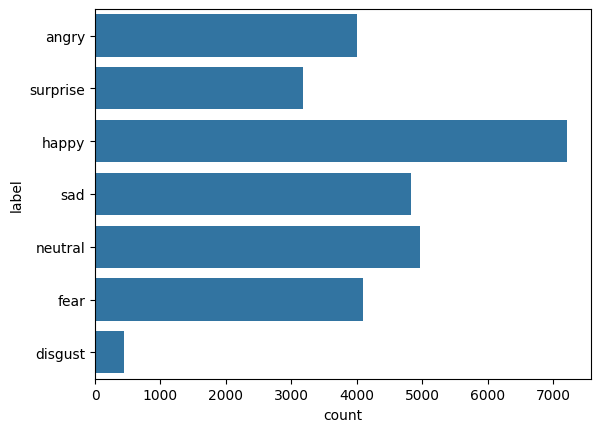

In [ ]:
sns.countplot(train['label'])

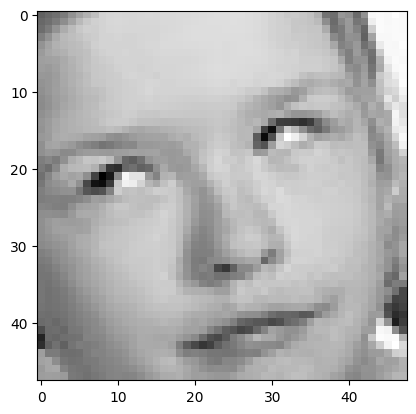

In [ ]:
from PIL import Image  # Python Imaging Library, used for handling image files
img = Image.open(train['image'][0])
plt.imshow(img, cmap='gray')

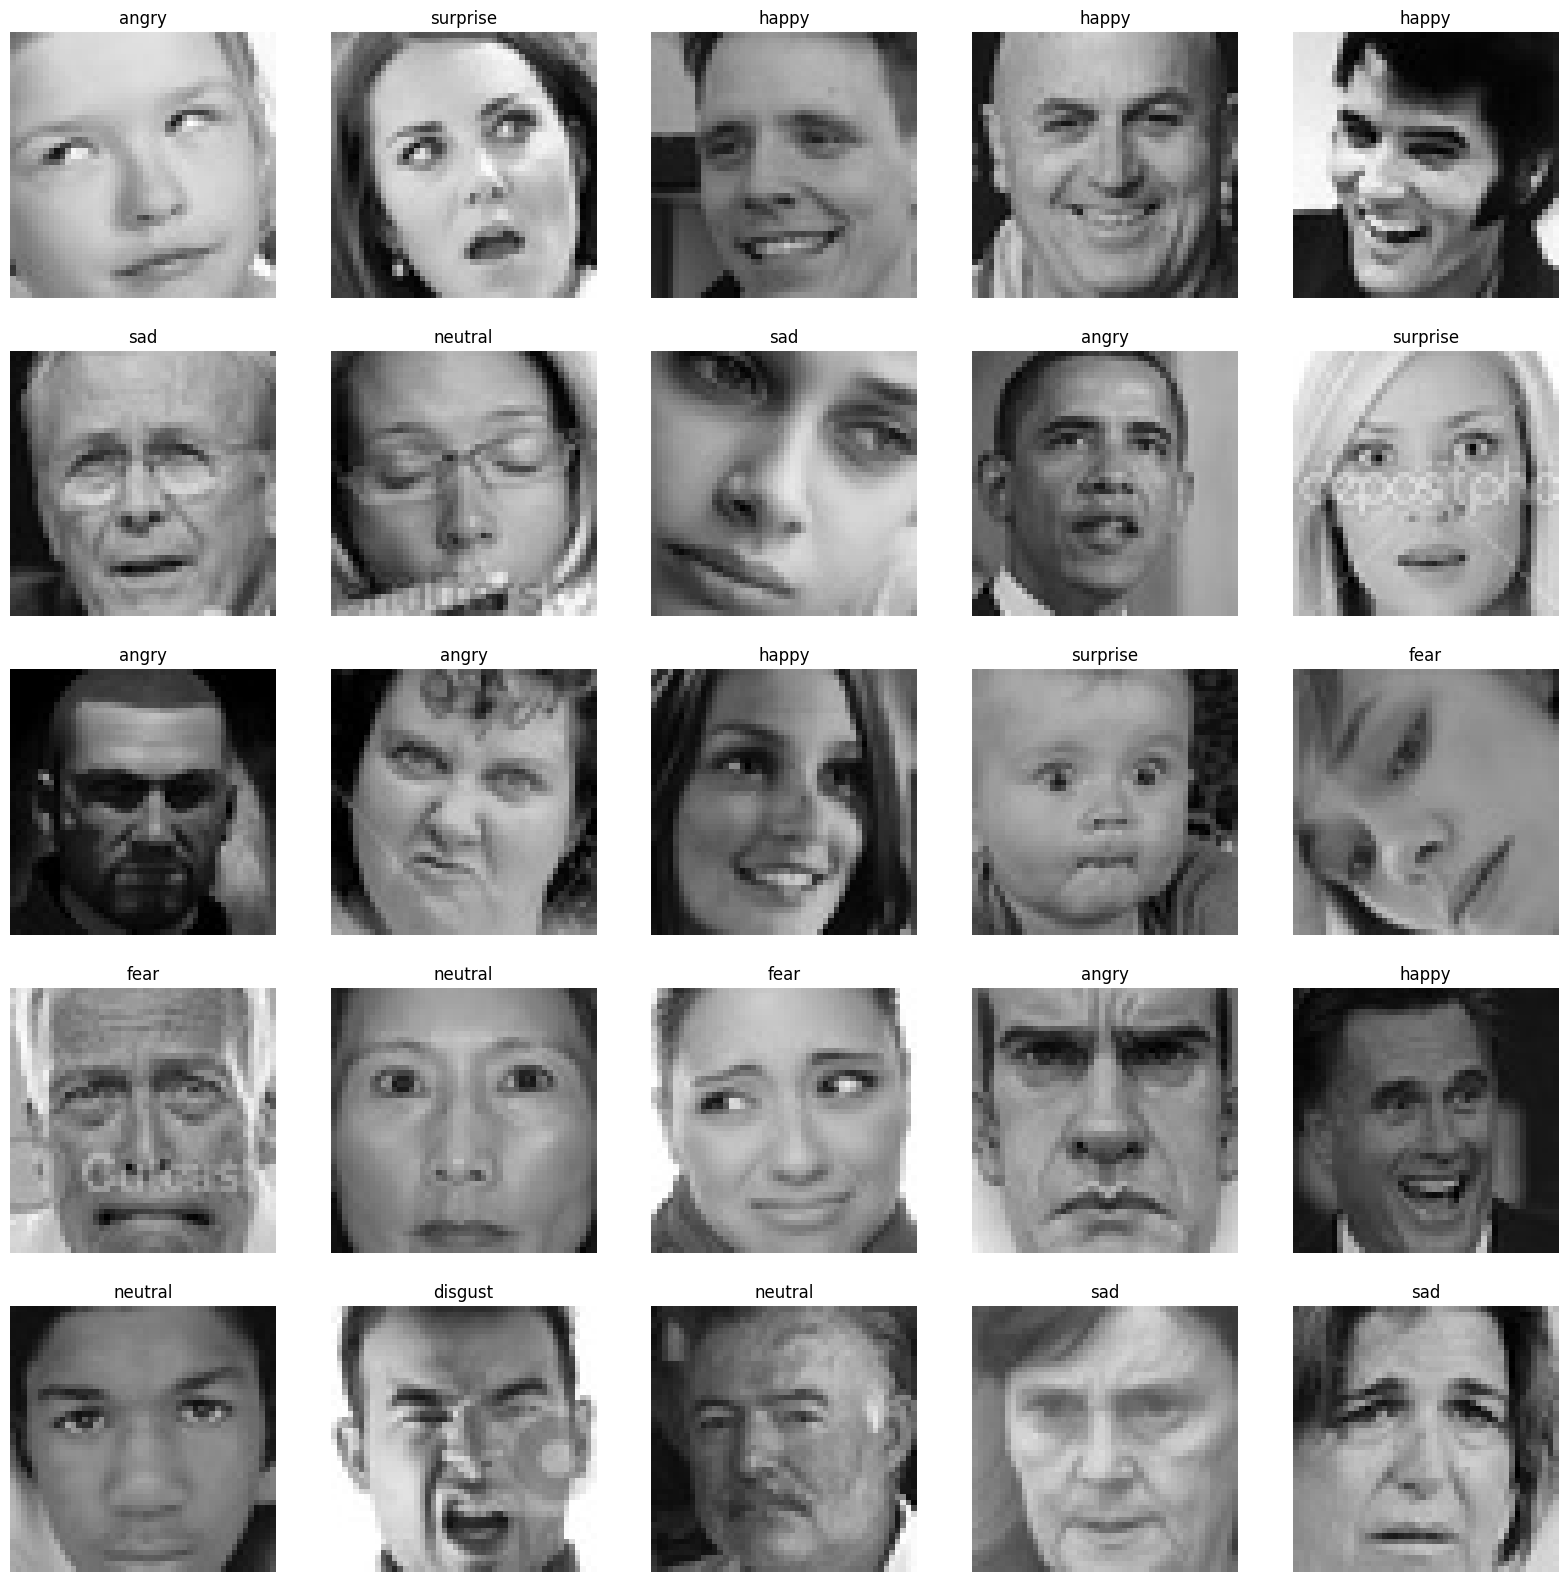

In [ ]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

Feature extraction

In [ ]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features

train_features = extract_features(train['image'])
test_features = extract_features(test['image'])


  0%|          | 0/28709 [00:00<?, ?it/s]

  0%|          | 0/7178 [00:00<?, ?it/s]

In [ ]:
## normalize the image
x_train = train_features/255.0
x_test = test_features/255.0
#img pixel values are in the range of 1-255,
#so here we're converting in the range of 0-1 so that it's easy for the nn to capture info

In [ ]:
## convert label to integer(surprised-0-10)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [ ]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [ ]:

y_train[0]

array([1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
# config
input_shape = (48, 48, 1)
output_class = 7

In [ ]:
model = Sequential()
# convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())

# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

# output layer
model.add(Dense(output_class, activation='softmax'))#softmax- multiclass classification

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [ ]:
# train the model

history = model.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
225/225 [==============================] - 1500s 7s/step - loss: 1.8228 - accuracy: 0.2473 - val_loss: 1.8139 - val_accuracy: 0.2471
Epoch 2/100
225/225 [==============================] - 1510s 7s/step - loss: 1.8007 - accuracy: 0.2508 - val_loss: 1.7420 - val_accuracy: 0.2871
Epoch 3/100
225/225 [==============================] - 1524s 7s/step - loss: 1.7014 - accuracy: 0.3080 - val_loss: 1.5657 - val_accuracy: 0.3734
Epoch 4/100
225/225 [==============================] - 1524s 7s/step - loss: 1.5591 - accuracy: 0.3883 - val_loss: 1.4422 - val_accuracy: 0.4471
Epoch 5/100
225/225 [==============================] - ETA: 0s - loss: 1.4659 - accuracy: 0.4325

<function matplotlib.pyplot.show(close=None, block=None)>

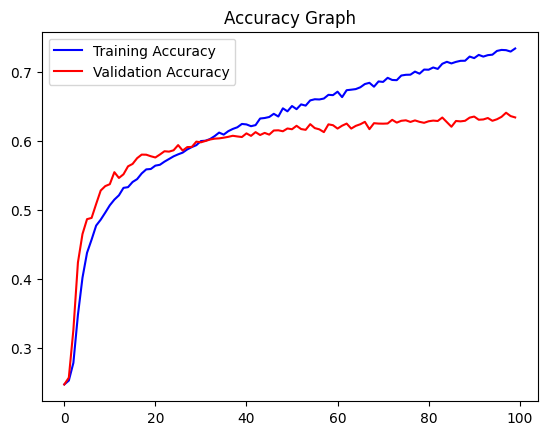

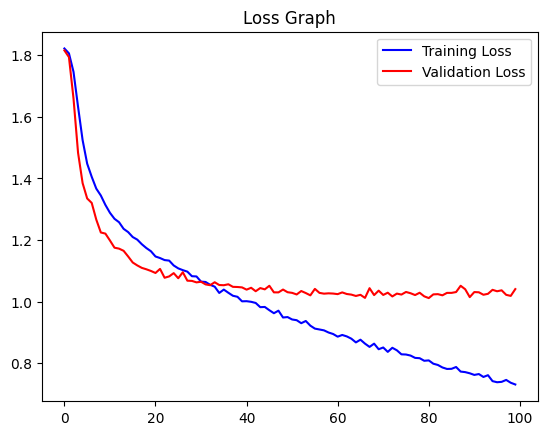

In [ ]:
#plot the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show

Original Output: neutral
1/1 [==============================] - 0s 492ms/step
Predicted Output: neutral


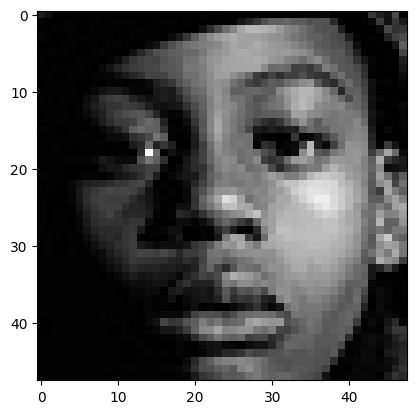

In [ ]:
#Test with Image Data
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');